In [1]:
# Importing all the libraries
import numpy as np
import pandas as pd
import random
import scipy as sp
from sklearn.decomposition import TruncatedSVD
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import string
nltk.download('stopwords')
nltk.download('punkt')



import gensim.downloader as api

[nltk_data] Downloading package stopwords to C:\Users\Rohit
[nltk_data]     Sharma\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to C:\Users\Rohit
[nltk_data]     Sharma\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


### 1. Performing Binary Classification where if overall = 4,5 the our target sentiment  = "good i.e 1" else "bad i.e 0"
### 2. Reading the data, analysing the data using Plots and summaries
### 3. The analysis shows that the data is biased since the positive setiment is 10x more than the negative sentiment (Neutral==3 was discarded in the analysis)
### 4. The data is then splitted to training, validation and test
### 5. The training dataset is used as a corpus to build a co-ocurrrence matrix and word2index hashmap
### 6. SVD was performed by using sklearn package to reduce the dimensionality of our co co-ocurrrence matrix
### 7. Plotted a scatter plot for certain words to understand the similarity using user defined function and Glove(where only two components were considerd to build the reduced co-occurence matrix in Glove)
### 8. The scatter plot plotted using the Co-occurence matrix gernerated by the user-defined function have better similarity index between words and similar words are closed compared to Glove implementation
### 9. Finally k=128 components were extracted usign SVD from the original co-occurence matrix and final embeddings were generated to be used to train the model
### 10. Final embeddibngs for both validation and test set were also generated
### 11. Logistic regression and Newural Network was implemented

### Note: After performing the validation, the best set of architecture and hyperparameters were chosen but model was not retrained on training + validation data and used directly to perform predictions on test dataset




# Task 1: Extracting features

### 1. Data Preprocessing

In [2]:
data = pd.read_csv("D:/Stevens/CS 584/amazon_reviews.csv")

In [3]:
data.shape

(4915, 2)

In [4]:
data.head()

,overall,reviewText
0,4,No issues.
1,5,"Purchased this for my device, it worked as adv..."
2,4,it works as expected. I should have sprung for...
3,5,This think has worked out great.Had a diff. br...
4,5,"Bought it with Retail Packaging, arrived legit..."


In [5]:
# FIltering out neutral reviews
data_filtered = data[data['overall'] != 3]

In [6]:
# Creating a target label "sentiment" conatining binary classification 0/1
data_filtered['sentiment'] = data_filtered['overall'].apply(lambda x: 1 if x in [4, 5] else 0)

C:\Users\Rohit Sharma\AppData\Local\Temp\ipykernel_8968\1162351332.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_filtered['sentiment'] = data_filtered['overall'].apply(lambda x: 1 if x in [4, 5] else 0)


In [7]:
data_filtered.head()

,overall,reviewText,sentiment
0,4,No issues.,1
1,5,"Purchased this for my device, it worked as adv...",1
2,4,it works as expected. I should have sprung for...,1
3,5,This think has worked out great.Had a diff. br...,1
4,5,"Bought it with Retail Packaging, arrived legit...",1


In [8]:
data_filtered.shape

(4773, 3)

In [9]:
data_filtered.isna().value_counts()

overall  reviewText  sentiment
False    False       False        4772
         True        False           1
dtype: int64

In [10]:
data_filtered[data_filtered["reviewText"].isna()]

,overall,reviewText,sentiment
125,5,NaN,1


In [11]:
data_filtered = data_filtered.dropna()

In [12]:
data_filtered.isna().value_counts()

overall  reviewText  sentiment
False    False       False        4772
dtype: int64

#### Converting all texts to lower to maintain uniformity

In [13]:
for i in range(data_filtered.shape[0]):
    data_filtered.iloc[i, 1] = data_filtered.iloc[i, 1].lower()

In [14]:
data_filtered.head(20)

,overall,reviewText,sentiment
0,4,no issues.,1
1,5,"purchased this for my device, it worked as adv...",1
2,4,it works as expected. i should have sprung for...,1
3,5,this think has worked out great.had a diff. br...,1
4,5,"bought it with retail packaging, arrived legit...",1
5,5,it's mini storage. it doesn't do anything els...,1
6,5,i have it in my phone and it never skips a bea...,1
7,5,it's hard to believe how affordable digital ha...,1
8,5,works in a htc rezound. was running short of ...,1
9,5,"in my galaxy s4, super fast card, and am total...",1


In [15]:
# Processing the corpus and generating tokens 

def tokenize_review(review):
    # Remove punctuation
    review = review.translate(str.maketrans('', '', string.punctuation))

    # Remove numbers
    review = ''.join([i for i in review if not i.isdigit()])

    # Tokenize the review
    tokens = word_tokenize(review)

    # Remove stopwords
    stop_words = set(stopwords.words('english'))
    tokens = [token for token in tokens if token.lower() not in stop_words]

    return tokens

data_filtered['tokenized_review'] = data_filtered['reviewText'].apply(tokenize_review)


In [16]:
data_filtered["tokenized_review"]

0                                                [issues]
1       [purchased, device, worked, advertised, never,...
2       [works, expected, sprung, higher, capacity, th...
3       [think, worked, greathad, diff, bran, gb, card...
4       [bought, retail, packaging, arrived, legit, or...
                              ...                        
4910    [bought, sandisk, gb, class, use, htc, inspire...
4911    [used, extending, capabilities, samsung, galax...
4912    [great, card, fast, reliable, comes, optional,...
4913    [good, amount, space, stuff, want, fits, gopro...
4914    [ive, heard, bad, things, gb, micro, sd, card,...
Name: tokenized_review, Length: 4772, dtype: object

In [17]:
# Split the data into training (80%), validation(10%), and testing (10%)

X = data_filtered['tokenized_review']
y = data_filtered['sentiment']
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.2, random_state=39)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=28)

print(f"Training set size: {len(X_train)}")
print(f"Validation set size: {len(X_val)}")
print(f"Testing set size: {len(X_test)}")


Training set size: 3817
Validation set size: 477
Testing set size: 478


In [18]:
X_train

2989    [nice, gb, micro, sd, card, using, one, samsun...
2287    [exclusively, used, sandisk, extreme, cards, p...
1114    [using, strongly, suggest, format, card, takes...
939     [must, listen, lot, music, gowish, made, gb, m...
1783    [needed, micro, sd, card, storage, phone, good...
                              ...                        
3280    [phones, internal, memory, nearly, always, ful...
2331    [fastest, microsdhc, ive, used, got, tablet, t...
1118    [perfect, ss, galaxy, note, great, price, reco...
107     [bought, two, one, asus, infinity, one, samsun...
3558    [use, hd, video, recording, work, well, frame,...
Name: tokenized_review, Length: 3817, dtype: object

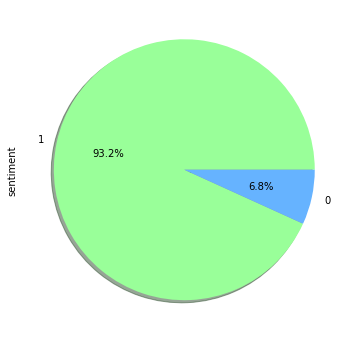

1    93.210394
0     6.789606
Name: sentiment, dtype: float64

In [20]:
colors_plt = ['#99ff99','#66b3ff','#ffcc99','#ff9999']
data_filtered['sentiment'].value_counts().plot.pie(autopct='%1.1f%%', shadow=True, figsize=(6,6), colors=colors_plt)
plt.show()
data_filtered["sentiment"].value_counts()*100/(data_filtered.shape[0])

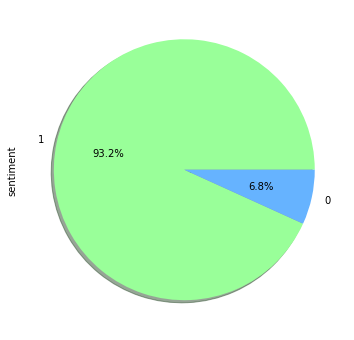

1    3558
0     259
Name: sentiment, dtype: int64

In [21]:
colors_plt = ['#99ff99','#66b3ff','#ffcc99','#ff9999']
y_train.value_counts().plot.pie(autopct='%1.1f%%', shadow=True, figsize=(6,6), colors=colors_plt)
plt.show()
y_train.value_counts()

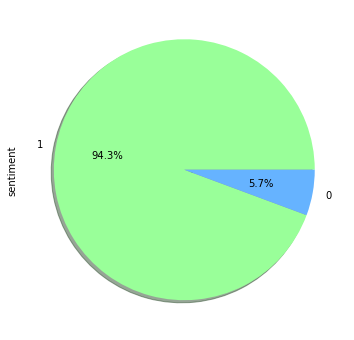

1    450
0     27
Name: sentiment, dtype: int64

In [22]:
colors_plt = ['#99ff99','#66b3ff','#ffcc99','#ff9999']
y_val.value_counts().plot.pie(autopct='%1.1f%%', shadow=True, figsize=(6,6), colors=colors_plt)
plt.show()
y_val.value_counts()

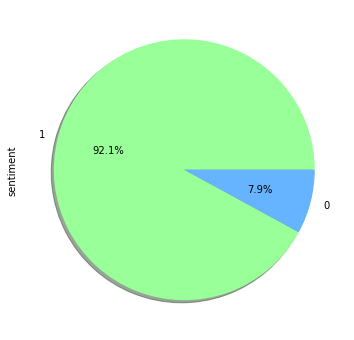

1    440
0     38
Name: sentiment, dtype: int64

In [23]:
colors_plt = ['#99ff99','#66b3ff','#ffcc99','#ff9999']
y_test.value_counts().plot.pie(autopct='%1.1f%%', shadow=True, figsize=(6,6), colors=colors_plt)
plt.show()
y_test.value_counts()

In [24]:
data_filtered.describe()

,overall,sentiment
count,4772.000000,4772.000000
mean,4.634744,0.932104
std,0.972732,0.251594
min,1.000000,0.000000
25%,5.000000,1.000000
50%,5.000000,1.000000
75%,5.000000,1.000000
max,5.000000,1.000000


In [25]:
data_filtered.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4772 entries, 0 to 4914
Data columns (total 4 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   overall           4772 non-null   int64 
 1   reviewText        4772 non-null   object
 2   sentiment         4772 non-null   int64 
 3   tokenized_review  4772 non-null   object
dtypes: int64(2), object(2)
memory usage: 186.4+ KB


In [26]:
data_filtered["overall"].value_counts()

5    3921
4     527
1     244
2      80
Name: overall, dtype: int64

In [27]:
max_tokens_index = X_train.apply(len).idxmax()
print(f"Maximum number of tokens:\n{X_train[max_tokens_index]}")
print(len(X_train[max_tokens_index]))

min_tokens_index = X_train.apply(len).idxmin()
print(f"Minimum number of tokens:\n{X_train[min_tokens_index]}")
print(len(X_train[min_tokens_index]))


Maximum number of tokens:
['note', 'please', 'read', 'last', 'update', 'scroll', 'bottom', 'im', 'leaving', 'review', 'star', 'appears', 'help', 'others', 'purchased', 'similar', 'experiencei', 'give', 'sandisk', 'stars', 'customer', 'service', 'star', 'product', 'manufactured', 'past', 'newly', 'manufactured', 'products', 'contain', 'software', 'rom', 'fix', 'id', 'give', 'product', 'starsto', 'purchased', 'card', 'due', 'great', 'reviews', 'used', 'galaxy', 'gs', 'smartphone', 'storage', 'solution', 'problem', 'one', 'solve', 'without', 'returning', 'card', 'sandisk', 'replacement', 'warranty', 'believe', 'tried', 'everything', 'google', 'searches', 'returned', 'solutions', 'formatting', 'exfat', 'formatting', 'gs', 'copying', 'data', 'card', 'phone', 'etc', 'nothing', 'worked', 'please', 'stop', 'pulling', 'hair', 'hopefully', 'get', 'result', 'hope', 'get', 'soon', 'rmad', 'send', 'back', 'tomorrow', 'free', 'replacement', 'warrantythe', 'problem', 'confirmed', 'sandisk', 'customer

In [28]:
max_tokens_index = X_val.apply(len).idxmax()
print(f"Maximum number of tokens:\n{X_val[max_tokens_index]}")
print(len(X_val[max_tokens_index]))

min_tokens_index = X_val.apply(len).idxmin()
print(f"Minimum number of tokens:\n{X_val[min_tokens_index]}")
print(len(X_val[min_tokens_index]))

Maximum number of tokens:
['primary', 'reason', 'buying', 'extra', 'capacitysandisk', 'ultra', 'gb', 'microsdxc', 'class', 'card', 'use', 'insamsung', 'galaxy', 'tab', 'inch', 'model', 'gtpand', 'happy', 'share', 'get', 'work', 'flawlessly', 'initial', 'glitches', 'read', 'belowfirstly', 'need', 'aware', 'samsung', 'tablet', 'model', 'gtp', 'currently', 'runs', 'android', 'os', 'kernel', 'build', 'number', 'jrocpueclkjelly', 'bean', 'experiences', 'shared', 'level', 'android', 'os', 'experiences', 'may', 'vary', 'depending', 'version', 'os', 'running', 'sandisk', 'ultra', 'gb', 'microsdxc', 'card', 'purchased', 'amazon', 'retail', 'packaging', 'gets', 'recognized', 'fine', 'however', 'tablets', 'media', 'device', 'aka', 'mtp', 'application', 'attempts', 'talk', 'pc', 'via', 'usb', 'cable', 'tablet', 'simply', 'reboots', 'card', 'presented', 'pc', 'really', 'strange', 'indeedthis', 'baffled', 'couple', 'hours', 'firstly', 'attempted', 'format', 'card', 'exfat', 'pc', 'formatted', 'fine'

In [29]:
max_tokens_index = X_test.apply(len).idxmax()
print(f"Maximum number of tokens:\n{X_test[max_tokens_index]}")
print(len(X_test[max_tokens_index]))

min_tokens_index = X_test.apply(len).idxmin()
print(f"Minimum number of tokens:\n{X_test[min_tokens_index]}")
print(len(X_test[min_tokens_index]))

Maximum number of tokens:
['bought', 'gb', 'version', 'card', 'use', 'gopro', 'hero', 'black', 'edition', 'didnt', 'work', 'card', 'worked', 'ok', 'camera', 'set', 'resolution', 'lower', 'bit', 'rates', 'eg', 'worked', 'fine', 'p', 'protune', 'p', 'protune', 'however', 'p', 'protune', 'bitrate', 'shy', 'mbs', 'mode', 'much', 'higher', 'protune', 'turned', 'nothing', 'trouble', 'camera', 'would', 'sometime', 'work', 'sometime', 'randomly', 'stop', 'recording', 'obvious', 'reason', 'first', 'suspected', 'camera', 'testing', 'different', 'sd', 'cards', 'ended', 'sandisks', 'card', 'fault', 'spare', 'card', 'old', 'cheap', 'gb', 'pny', 'also', 'class', 'worked', 'fine', 'conditions', 'camera', 'settingsonce', 'obvious', 'problem', 'card', 'found', 'people', 'gopros', 'forums', 'trouble', 'specific', 'card', 'well', 'well', 'always', 'find', 'figure', 'right', 'anyhow', 'speed', 'tests', 'card', 'simple', 'write', 'gb', 'file', 'full', 'zeros', 'using', 'unix', 'dd', 'utility', 'copy', 'gb'

## 2. Representation of Texts: word vectors (40 points)

In [30]:
# Defining a function to return set of unique words in the corpus
def get_vacab(corpus):
    corpus_words = list(set(x for i in corpus for x in i))
    corpus_words = sorted(corpus_words)
    return corpus_words

In [31]:
#  Defining a function to calculate the co-occurence matrix and generating hashmap
def compute_co_occurrence_matrix(corpus, window_size=4):
    word2index = {}
    corpus_words = get_vacab(corpus)

    # The below function generates a hashmap of tokens and it's corresponding index
    for index, element in enumerate(corpus_words):
        if element not in word2index:
            word2index[element] = index

    co_occurrence_matrix = np.zeros((len(corpus_words), len(corpus_words)))

    for review in corpus:
        for index, word in enumerate(review):
            # Since the corpus has varied length of tokens, we want to ensure that correct indexes
            # were used to calculate the co-occurence matrix so defining conditions to get start and end indexes for calculation 
            start = max(0, index - window_size)
            end = min(len(review), index + window_size + 1)

            for word_i in range(start, end):
                if word_i != index:
                    token = review[word_i]
                    if word in word2index and token in word2index:
                        co_occurrence_matrix[word2index[word]][word2index[token]] += 1
    return co_occurrence_matrix, word2index


In [32]:
co_occurrence_matrix , word2index = compute_co_occurrence_matrix(X_train, window_size=4)

In [33]:
co_occurrence_matrix.shape

(8390, 8390)

In [34]:
# Defining a function to reduce the dimensionality of Co-occurence matrix to K dimesnion using SVD from sklearn library
def reduce_to_k_dim(M, k):
    svd = TruncatedSVD(n_components=k, n_iter=10, random_state=89)
    M_reduced = svd.fit_transform(M)
    return M_reduced

In [35]:
k = 150
M_reduced = reduce_to_k_dim(co_occurrence_matrix, k)

In [36]:
M_reduced.shape

(8390, 150)

In [37]:
M_reduced[0].shape

(150,)

In [38]:
# Defining a function to plot a scatter plot for a given set of words

def plot_embeddings(M_reduced, word2index, words_to_plot):
    indices_to_plot = [word2index[word] for word in words_to_plot]
    words_to_plot_coords = M_reduced[indices_to_plot]
    print(M_reduced[indices_to_plot].shape)

    plt.figure(figsize=(10, 8))
    plt.scatter(words_to_plot_coords[:, 0], words_to_plot_coords[:, 1], c='blue', edgecolors='k')
    for word, coords in zip(words_to_plot, words_to_plot_coords):
        plt.text(coords[0], coords[1], word)

    plt.grid(True)
    plt.show()


(10, 150)


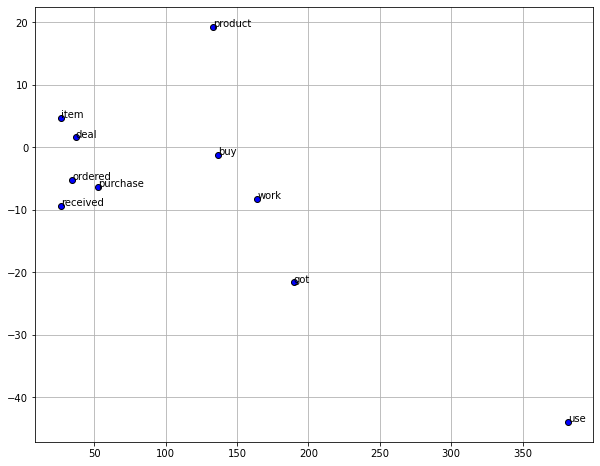

In [39]:
# Given set of words mentioned in the assignment that needs to plotted in the scatter plot
words_to_plot = ['purchase', 'buy', 'work', 'got', 'ordered', 'received', 'product', 'item', 'deal', 'use']

plot_embeddings(M_reduced, word2index, words_to_plot)


### 2. Prediction-based word vectors from Glove

In [40]:
# Loading the relevant models to implement Glove
def load_embedding_model():
    wv_from_bin = api.load("glove-wiki-gigaword-200")
    print("Loaded vocab size %i" % len(list(wv_from_bin.index_to_key)))
    return wv_from_bin
wv_from_bin = load_embedding_model()

Loaded vocab size 400000


In [41]:
def get_matrix_of_vectors(wv_from_bin, required_words):
    """ Put the GloVe vectors into a matrix M.
        Param:
            wv_from_bin: KeyedVectors object; the 400000 GloVe vectors loaded from file
        Return:
            M: numpy matrix shape (num words, 200) containing the vectors
            word2ind: dictionary mapping each word to its row number in M
    """
    import random
    words = list(wv_from_bin.index_to_key)
    print("Shuffling words ...")
    random.seed(225)
    random.shuffle(words)
    words = words[:10000]
    print("Putting %i words into word2ind and matrix M..." % len(words))
    word2ind = {}
    M = []
    curInd = 0
    for w in words:
        try:
            M.append(wv_from_bin.get_vector(w))
            word2ind[w] = curInd
            curInd += 1
        except KeyError:
            continue
    for w in required_words:
        if w in words:
            continue
        try:
            M.append(wv_from_bin.get_vector(w))
            word2ind[w] = curInd
            curInd += 1
        except KeyError:
            continue
    M = np.stack(M)
    print("Done.")

    return M, word2ind

In [42]:
# This function was designed to perform some testing and needs to skipped

# def get_matrix_of_vectors(wv_from_bin, required_words):
#     """ Put the GloVe vectors into a matrix M.
#         Param:
#             wv_from_bin: KeyedVectors object; the 400000 GloVe vectors loaded from file
#         Return:
#             M: numpy matrix shape (num words, 200) containing the vectors
#             word2ind: dictionary mapping each word to its row number in M
#     """
#     word2ind = {}#{required_words[i]:i for i in range(len(required_words))}
#     M=[]
#     for i in range(len(required_words)):
#         if required_words[i]in wv_from_bin.index_to_key:
#             M.append(wv_from_bin.get_vector(required_words[i]))
#             word2ind[required_words[i]]=len(M)-1
#     M=np.stack(M)
#     return M, word2ind

In [43]:
M, word2ind = get_matrix_of_vectors(wv_from_bin,get_vacab(X_train))

Shuffling words ...
Putting 10000 words into word2ind and matrix M...
Done.


In [44]:
M.shape

(15668, 200)

In [45]:
k = 2
M_reduced_1 = reduce_to_k_dim(M, k)

(10, 2)


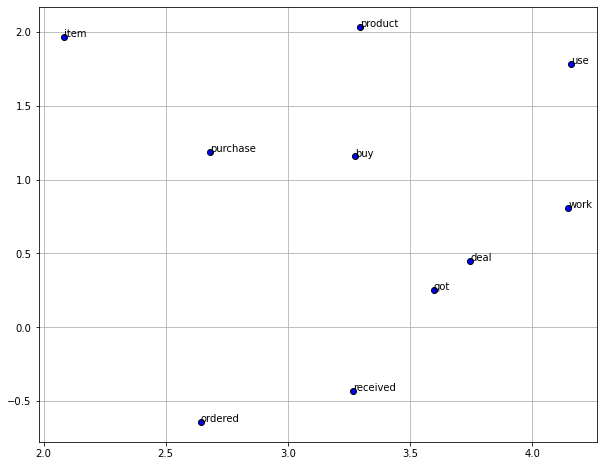

In [46]:
plot_embeddings(M_reduced_1, word2ind, words_to_plot)

#### 2) d. Observations between plots

##### 1. Since we are reducing the k dimensions to 2 in Glove the words are separated more in the scatter plot compared to the previous scatter plot

### Task 2: Sentiment Classification Algorithms
#### Perform sentiment analysis with classification

In [47]:
k = 128
M_reduced_2 = reduce_to_k_dim(co_occurrence_matrix, k)

In [48]:
review_embeddings = []
# Generating final emebeddings of the training dataset that can be fed to the model 
for review in X_train:
    # Getting indices of words in the review
    word_indices = [word2index[word] for word in review if word in word2index]

    if not word_indices:
        continue

    # Get word embeddings for the review
    review_word_embeddings = M_reduced_2[word_indices]

    # Averaging the embedding vector for all the embedings in a datapoint
    review_embedding = np.mean(review_word_embeddings, axis=0)

    review_embeddings.append(review_embedding)

final_embeddings_train  = np.stack(review_embeddings)



In [49]:
final_embeddings_train.shape

(3817, 128)

In [50]:
y_train

2989    1
2287    0
1114    1
939     1
1783    1
       ..
3280    1
2331    1
1118    1
107     1
3558    1
Name: sentiment, Length: 3817, dtype: int64

In [51]:
review_embeddings = []

for review in X_val:
    word_indices = [word2index[word] for word in review if word in word2index]

    if not word_indices:
        continue

    review_word_embeddings = M_reduced_2[word_indices]
    review_embedding = np.mean(review_word_embeddings, axis=0)
    review_embeddings.append(review_embedding)
final_embeddings_val  = np.stack(review_embeddings)

In [52]:
final_embeddings_val.shape

(477, 128)

In [53]:
review_embeddings = []

for review in X_test:
    word_indices = [word2index[word] for word in review if word in word2index]

    if not word_indices:
        continue

    review_word_embeddings = M_reduced_2[word_indices]
    review_embedding = np.mean(review_word_embeddings, axis=0)
    review_embeddings.append(review_embedding)
final_embeddings_test  = np.stack(review_embeddings)

In [54]:
final_embeddings_test.shape

(478, 128)

In [55]:
import warnings
warnings.filterwarnings("ignore")


Report for C=0.1
Validation Accuracy: 0.9538784067085954
Validation AUC: 0.6970370370370371
Validation Classification Report:
               precision    recall  f1-score   support

           0       0.65      0.41      0.50        27
           1       0.97      0.99      0.98       450

    accuracy                           0.95       477
   macro avg       0.81      0.70      0.74       477
weighted avg       0.95      0.95      0.95       477



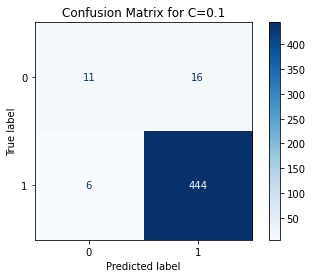


Report for C=0.3
Validation Accuracy: 0.9580712788259959
Validation AUC: 0.7340740740740741
Validation Classification Report:
               precision    recall  f1-score   support

           0       0.68      0.48      0.57        27
           1       0.97      0.99      0.98       450

    accuracy                           0.96       477
   macro avg       0.83      0.73      0.77       477
weighted avg       0.95      0.96      0.95       477



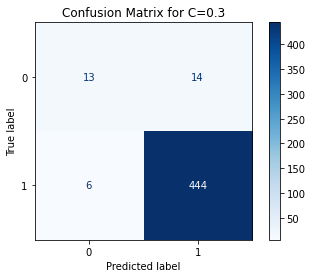


Report for C=0.5
Validation Accuracy: 0.9517819706498952
Validation AUC: 0.7307407407407407
Validation Classification Report:
               precision    recall  f1-score   support

           0       0.59      0.48      0.53        27
           1       0.97      0.98      0.97       450

    accuracy                           0.95       477
   macro avg       0.78      0.73      0.75       477
weighted avg       0.95      0.95      0.95       477



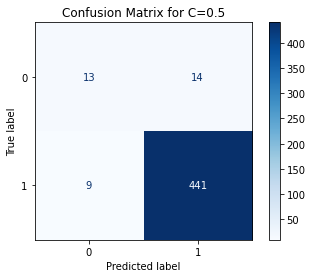


Report for C=0.7
Validation Accuracy: 0.9517819706498952
Validation AUC: 0.7307407407407407
Validation Classification Report:
               precision    recall  f1-score   support

           0       0.59      0.48      0.53        27
           1       0.97      0.98      0.97       450

    accuracy                           0.95       477
   macro avg       0.78      0.73      0.75       477
weighted avg       0.95      0.95      0.95       477



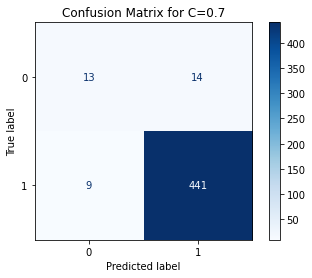


Report for C=1.0
Validation Accuracy: 0.949685534591195
Validation AUC: 0.7296296296296296
Validation Classification Report:
               precision    recall  f1-score   support

           0       0.57      0.48      0.52        27
           1       0.97      0.98      0.97       450

    accuracy                           0.95       477
   macro avg       0.77      0.73      0.75       477
weighted avg       0.95      0.95      0.95       477



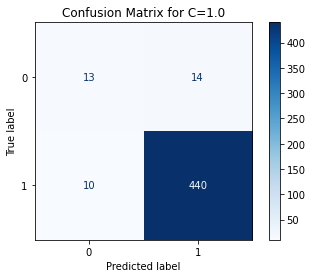

In [56]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report,roc_auc_score,confusion_matrix, plot_confusion_matrix

# The hyperparameter C that controls the strength of regularization is tuned and the best model is selected

for C in [0.1, 0.3, 0.5, 0.7 ,1.0]:
    model1 = LogisticRegression(penalty='l2', C=C, max_iter=1000)
    model1.fit(final_embeddings_train, y_train)

    y_val_pred = model1.predict(final_embeddings_val)

    # Print reports for each C value including but not limited to accuracy, classification report, auc and cnfusion matrix
    print(f"\nReport for C={C}")
    print("Validation Accuracy:", accuracy_score(y_val, y_val_pred))
    print("Validation AUC:", roc_auc_score(y_val, y_val_pred))
    print("Validation Classification Report:\n", classification_report(y_val, y_val_pred))
    conf_matrix = confusion_matrix(y_val, y_val_pred)
    plot_confusion_matrix(model1, final_embeddings_val, y_val, cmap='Blues')
    plt.title(f'Confusion Matrix for C={C}')
    plt.show()

Test Accuracy: 0.9351464435146444
Test AUC: 0.7483851674641149
Test Classification Report:
               precision    recall  f1-score   support

           0       0.61      0.53      0.56        38
           1       0.96      0.97      0.96       440

    accuracy                           0.94       478
   macro avg       0.78      0.75      0.76       478
weighted avg       0.93      0.94      0.93       478



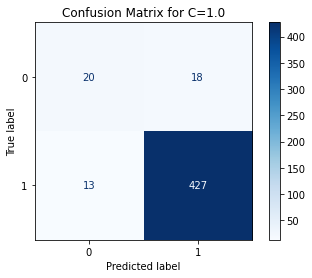

In [57]:
# Final model is trained using C=0.3 and training dataset only which generates the best results among all hyperparameters
model2 = LogisticRegression(penalty='l2', C=0.3, max_iter=1000)
model2.fit(final_embeddings_train, y_train)
y_test_pred = model2.predict(final_embeddings_test)
print("Test Accuracy:", accuracy_score(y_test, y_test_pred))
print("Test AUC:", roc_auc_score(y_test, y_test_pred))
print("Test Classification Report:\n", classification_report(y_test, y_test_pred))
conf_matrix = confusion_matrix(y_test, y_test_pred)
plot_confusion_matrix(model2, final_embeddings_test, y_test, cmap='Blues')
plt.title(f'Confusion Matrix for C={C}')
plt.show()

Epoch 1/5
120/120 [==============================] - 2s 5ms/step - loss: 1.3820 - accuracy: 0.8968 - val_loss: 0.5351 - val_accuracy: 0.9434
Epoch 2/5
120/120 [==============================] - 0s 2ms/step - loss: 0.7199 - accuracy: 0.9059 - val_loss: 0.3086 - val_accuracy: 0.9476
Epoch 3/5
120/120 [==============================] - 0s 2ms/step - loss: 0.4628 - accuracy: 0.9172 - val_loss: 0.2834 - val_accuracy: 0.9434
Epoch 4/5
120/120 [==============================] - 0s 1ms/step - loss: 0.2948 - accuracy: 0.9219 - val_loss: 0.2588 - val_accuracy: 0.9434
Epoch 5/5
15/15 [==============================] - 0s 811us/step
Validation Accuracy: 0.9517819706498952
Validation AUC: 0.6611111111111112
              precision    recall  f1-score   support

           0       0.64      0.33      0.44        27
           1       0.96      0.99      0.97       450

    accuracy                           0.95       477
   macro avg       0.80      0.66      0.71       477
weighted avg       0.94 

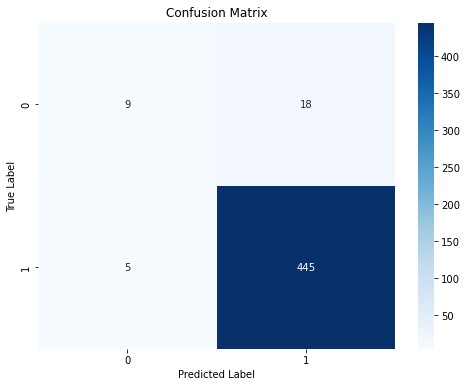

In [58]:
import tensorflow as tf
import seaborn as sns


# Build the sequential Nueral Net model
model3 = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(128,)),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

# Compile the model
model3.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

# Train the model
model3.fit(final_embeddings_train, y_train, epochs=5, batch_size=32, validation_data=(final_embeddings_val, y_val))

# Evaluate the model
y_pred = (model3.predict(final_embeddings_val) > 0.5).astype("int32")
print("Validation Accuracy:", accuracy_score(y_val, y_pred))
print("Validation AUC:", roc_auc_score(y_val, y_pred))
print(classification_report(y_val, y_pred))
conf_matrix = confusion_matrix(y_val, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['0', '1'], yticklabels=['0', '1'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

Epoch 1/10
60/60 [==============================] - 1s 4ms/step - loss: 3.2202 - accuracy: 0.8433 - val_loss: 1.4140 - val_accuracy: 0.9434
Epoch 2/10
60/60 [==============================] - 0s 2ms/step - loss: 1.8158 - accuracy: 0.8868 - val_loss: 0.9921 - val_accuracy: 0.9434
Epoch 3/10
60/60 [==============================] - 0s 2ms/step - loss: 1.3555 - accuracy: 0.8934 - val_loss: 0.7486 - val_accuracy: 0.9455
Epoch 4/10
60/60 [==============================] - 0s 2ms/step - loss: 1.0073 - accuracy: 0.9070 - val_loss: 0.5816 - val_accuracy: 0.9434
Epoch 5/10
60/60 [==============================] - 0s 2ms/step - loss: 0.7923 - accuracy: 0.9109 - val_loss: 0.4292 - val_accuracy: 0.9434
Epoch 6/10
60/60 [==============================] - 0s 2ms/step - loss: 0.5611 - accuracy: 0.9162 - val_loss: 0.3132 - val_accuracy: 0.9497
Epoch 7/10
60/60 [==============================] - 0s 2ms/step - loss: 0.4151 - accuracy: 0.9198 - val_loss: 0.2619 - val_accuracy: 0.9518
Epoch 8/10
60/60 [==

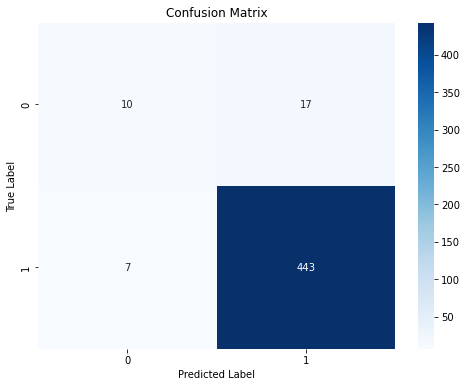

In [59]:
import tensorflow as tf

model4 = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(128,)),  
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dropout(0.7),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

# Compile the model
model4.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

# Train the model
model4.fit(final_embeddings_train, y_train, epochs=10, batch_size=64, validation_data=(final_embeddings_val, y_val))  # Increase epochs and batch size

# Evaluate the model
y_pred = (model4.predict(final_embeddings_val) > 0.5).astype("int32")
print("Validation Accuracy:", accuracy_score(y_val, y_pred))
print("Validation AUC:", roc_auc_score(y_val, y_pred))
print(classification_report(y_val, y_pred))
conf_matrix = confusion_matrix(y_val, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['0', '1'], yticklabels=['0', '1'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

15/15 [==============================] - 0s 1ms/step
Test Accuracy: 0.9456066945606695
Test AUC: 0.77811004784689
              precision    recall  f1-score   support

           0       0.69      0.58      0.63        38
           1       0.96      0.98      0.97       440

    accuracy                           0.95       478
   macro avg       0.83      0.78      0.80       478
weighted avg       0.94      0.95      0.94       478



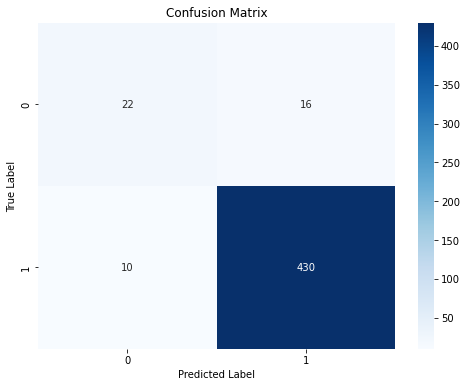

In [60]:
y_pred = (model4.predict(final_embeddings_test) > 0.5).astype("int32")
print("Test Accuracy:", accuracy_score(y_test, y_pred))
print("Test AUC:", roc_auc_score(y_test, y_pred))
print(classification_report(y_test, y_pred))
conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['0', '1'], yticklabels=['0', '1'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

### Observations based on the results obtained above

##### 1. In the Logistic regression performed, when C=0.3, we are getting the best accuracy, AUC and F1 score.
##### 2. Two differnt architecture of Neural Net was trained having different dropout rates to regularize the neural network
##### 3. The second architecture with higher dropout rate performs better
##### 4. Among Logistic Regression and Neural Network, Logistic Regression performs better since it has higher AUC and better F1 score than Neural Network for both the classes even though the accuracy of both the models is similar

